# 成功了，训练略慢，但是训练完的结果很好
# s,a他们在learn的时候都是一个，没有一批

squeeze的用法
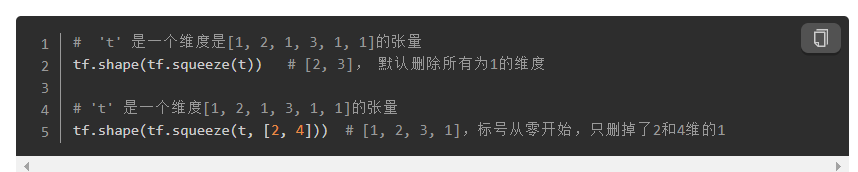

# tensorflow2.x怎么创建一个连续的正态分布呢？
安装tfp，就像安装tfa一样！
支持2.3.0以上版本，所以我直接安装了2.3.0-gpu版本，2.3.0很神奇，直接就
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [1]:
import numpy as np
import tensorflow as tf
import gym
import tensorflow_probability as tfp
import matplotlib.pyplot as plt


gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
#超参数
MAX_EPISODE = 500
MAX_EP_STEPS = 200
DISPLAY_REWARD_THRESHOLD = -90  # renders environment if total episode reward is greater then this threshold
RENDER = False  # rendering wastes time
GAMMA = 0.9
LR_A = 0.001    # learning rate for actor
LR_C = 0.01     # learning rate for critic

env = gym.make('Pendulum-v0')
env.seed(1)  # reproducible
env = env.unwrapped

N_S = env.observation_space.shape[0]
A_BOUND = env.action_space.high

# 定义一下计算高斯的函数
def gassian(mu,sigma,x):
    '''返回正态概率密度'''
    f_x = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return f_x

# 既然Actor生成的是分布的参数，那这种生成方式是否太过狭隘了，我认为这里生成分布完全可以用gan里面的generator生成分布

In [3]:
class Actor():
    def __init__(self,
                 n_features,
                 action_bound, #不再是动作个数了，而是浮点动作范围
                 lr=0.001):
        
        self.action_bound = action_bound
        #建立网络
        self.s = tf.keras.layers.Input(shape=(n_features,), name='state')
        l1 = tf.keras.layers.Dense(30, activation='relu', name='l1')(self.s)
        
        mu = tf.keras.layers.Dense(1,activation='tanh', name='mu')(l1)
        sigma = tf.keras.layers.Dense(1,activation='softplus', name='sigma')(l1)
        
        #Actor是一个多输出网络，一个输出是tanh处理的mu， 一个是softplus处理的sigma,这两个值对应着正态分布的均值和方差
        self.Actor_net = tf.keras.Model(inputs=self.s, outputs=[mu, sigma])
        
        #设置优化器
        self.a_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        
    def choose_action(self, s):
        s = np.expand_dims(s, axis=0)  #给s加一个维度，以便于可以输入网络
        [mu, sigma] = self.Actor_net(s)  # mu,sigma是一个正态分布的两个参数mu，sigma
         # 需要对这两个变量进行处理
        mu = tf.squeeze(mu*2)   #因为tanh输出[-1,1]而动作区间是[-2,2]，所以要乘2
        sigma = tf.squeeze(sigma + 0.1)
        #创建一个正态分布
        normal_dist = tfp.distributions.Normal(mu, sigma)
        act_choosed = tf.clip_by_value(normal_dist.sample(1), self.action_bound[0], self.action_bound[1])  
        
        return act_choosed

        
    def plot_gaosi(self,s):
        '''把生成的正态分布的图画出来'''
        s = np.expand_dims(s, axis=0)  #给s加一个维度，以便于可以输入网络
        [mu, sigma] = self.Actor_net(s)  # mu,sigma是一个正态分布的两个参数mu，sigma
         # 需要对这两个变量进行处理
        mu = tf.squeeze(mu*2)
        sigma = tf.squeeze(sigma + 0.1)
        #创建一个正态分布
        normal_dist = tfp.distributions.Normal(mu, sigma)
        #生成此次生成高斯分布的图像
        samples = normal_dist.sample(100)
        samples = samples.numpy()
        samples.sort()
        samplrs_prob_density = [gassian(mu,sigma,v) for v in samples]
        print('mu is ',mu)
        print('sigma is ',sigma)
        plt.plot(samples, samplrs_prob_density)
        plt.title('prob density')
        plt.xlabel('data_sorted')
        plt.ylabel('prob_density')

        
    def learn(self, s, a, td_error):
        '''真实的参数都传进来'''
        s = np.expand_dims(s, axis=0)  #给s加一个维度，以便于可以输入网络
        
        with tf.GradientTape() as tape:

            [mu, sigma] = self.Actor_net(s)  # mu,sigma是一个正态分布的两个参数mu，sigma
            # 需要对这两个变量进行处理
            mu = tf.squeeze(mu*2)
            sigma = tf.squeeze(sigma + 0.1)
            
            
            #创建一个正态分布
            normal_dist = tfp.distributions.Normal(mu, sigma)
            log_prob = normal_dist.log_prob(a)           # 这里发生了大的变化，不是用math里的log了，而是用tfp里面的normal_dist自带的log_prob
            
            exp_v = log_prob * td_error
            exp_v += 0.01 * normal_dist.entropy()
            loss = -exp_v
            
        #计算梯度    
        gradients = tape.gradient(loss, self.Actor_net.trainable_variables)
        #优化
        self.a_optimizer.apply_gradients(zip(gradients, self.Actor_net.trainable_variables))
        
        return exp_v


In [4]:
class Critic():
    def __init__(self,
                 n_features,
                 lr=0.01):
        
        # 建立网络
        self.s = tf.keras.layers.Input(shape=(n_features,), name='state')
        l1 = tf.keras.layers.Dense(30, activation='relu', name='l1')(self.s)
        v = tf.keras.layers.Dense(1, name='V')(l1)
        
        #Critic还是一个单输出网络
        self.Critic_net = tf.keras.Model(inputs=self.s, outputs=v)
        
        #优化器
        self.c_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    def learn(self, s, r, s_):
        s = np.expand_dims(s, axis=0)
        s_ = np.expand_dims(s_, axis=0)
        
        with tf.GradientTape() as tape:
            v_ = self.Critic_net(s_)
            v = self.Critic_net(s)
            td_error = tf.reduce_mean(r + GAMMA * v_ - v)
            loss = tf.square(td_error)
        #计算梯度
        gradients = tape.gradient(loss, self.Critic_net.trainable_variables)
        #优化
        self.c_optimizer.apply_gradients(zip(gradients, self.Critic_net.trainable_variables))
        
        return td_error
        
    

In [5]:
actor = Actor(n_features=N_S, action_bound=[-A_BOUND, A_BOUND], lr=LR_A)
critic = Critic(n_features=N_S, lr=LR_C)     # we need a good teacher, so the teacher should learn faster than the actor

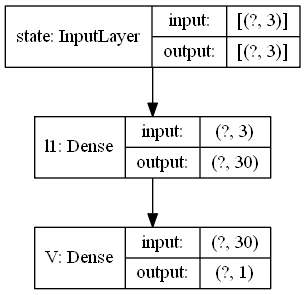

In [6]:
tf.keras.utils.plot_model(critic.Critic_net, show_shapes=True)

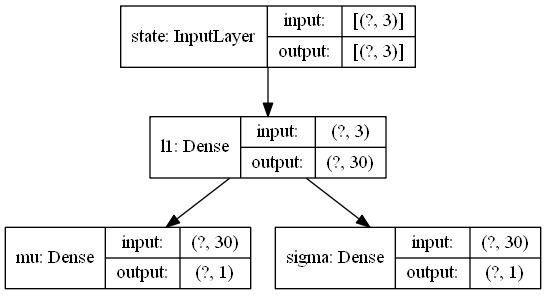

In [7]:
tf.keras.utils.plot_model(actor.Actor_net, show_shapes=True)

# 注意看下面这些代码，它是如何把一个没有回合的问题转成了有回合的问题，就是设置MAX_EP_STEPS，达到这个就算一回合，算法是单步学习，回合是用来显示reward的


In [8]:
for i_episode in range(MAX_EPISODE):
    s = env.reset()
    t = 0
    ep_rs = []
    while True:
        if RENDER: env.render()
        a = actor.choose_action(s)

        s_, r, done, info = env.step(a)
        r /= 10

        td_error = critic.learn(s, r, s_)  # gradient = grad[r + gamma * V(s_) - V(s)]
        actor.learn(s, a, td_error)  # true_gradient = grad[logPi(s,a) * td_error]

        s = s_
        t += 1
        ep_rs.append(r)
        if t > MAX_EP_STEPS:
            ep_rs_sum = sum(ep_rs)
            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.9 + ep_rs_sum * 0.1
            if running_reward > DISPLAY_REWARD_THRESHOLD: 
                RENDER = True  # rendering
                actor.Actor_net.save_weights('actor_weights1.h5')
                critic.Critic_net.save_weights('critic_weights1.h5')
            print("episode:", i_episode, "  reward:", int(running_reward))
            break

tf.Tensor([-1.587183], shape=(1,), dtype=float32)
tf.Tensor([-0.56070745], shape=(1,), dtype=float32)
tf.Tensor([-0.85594654], shape=(1,), dtype=float32)
tf.Tensor([-0.97998154], shape=(1,), dtype=float32)
tf.Tensor([-0.35023338], shape=(1,), dtype=float32)
tf.Tensor([-0.3289533], shape=(1,), dtype=float32)
tf.Tensor([-0.40535697], shape=(1,), dtype=float32)
tf.Tensor([-0.41474524], shape=(1,), dtype=float32)
tf.Tensor([-0.47123858], shape=(1,), dtype=float32)
tf.Tensor([-0.5399924], shape=(1,), dtype=float32)
tf.Tensor([-0.617293], shape=(1,), dtype=float32)
tf.Tensor([-1.5927069], shape=(1,), dtype=float32)
tf.Tensor([-0.7287505], shape=(1,), dtype=float32)
tf.Tensor([-0.77301246], shape=(1,), dtype=float32)
tf.Tensor([-0.8222385], shape=(1,), dtype=float32)
tf.Tensor([-0.88486487], shape=(1,), dtype=float32)
tf.Tensor([-1.6708188], shape=(1,), dtype=float32)
tf.Tensor([-1.0042241], shape=(1,), dtype=float32)
tf.Tensor([-0.8423064], shape=(1,), dtype=float32)
tf.Tensor([-1.2995855], 

tf.Tensor([-1.8339545], shape=(1,), dtype=float32)
tf.Tensor([-1.8540404], shape=(1,), dtype=float32)
tf.Tensor([-1.8450545], shape=(1,), dtype=float32)
tf.Tensor([-1.8284545], shape=(1,), dtype=float32)
tf.Tensor([-2.303468], shape=(1,), dtype=float32)
tf.Tensor([-1.8061076], shape=(1,), dtype=float32)
tf.Tensor([-1.8866098], shape=(1,), dtype=float32)
tf.Tensor([-1.636302], shape=(1,), dtype=float32)
tf.Tensor([-2.149496], shape=(1,), dtype=float32)
tf.Tensor([-3.2765732], shape=(1,), dtype=float32)
tf.Tensor([-1.6109037], shape=(1,), dtype=float32)
tf.Tensor([-2.0480275], shape=(1,), dtype=float32)
tf.Tensor([-1.6459233], shape=(1,), dtype=float32)
tf.Tensor([-2.0305247], shape=(1,), dtype=float32)
tf.Tensor([-3.2037811], shape=(1,), dtype=float32)
tf.Tensor([-1.7881984], shape=(1,), dtype=float32)
tf.Tensor([-3.127417], shape=(1,), dtype=float32)
tf.Tensor([-1.8430763], shape=(1,), dtype=float32)
tf.Tensor([-1.8886275], shape=(1,), dtype=float32)
tf.Tensor([-1.9185005], shape=(1,),

KeyboardInterrupt: 

# 测试

In [7]:
actor_test = Actor(n_features=N_S, action_bound=[-A_BOUND, A_BOUND], lr=LR_A)

In [8]:
actor_test.Actor_net.load_weights('actor_weights.h5')

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-1.9999317, shape=(), dtype=float32)
sigma is  tf.Tensor(233.52098, shape=(), dtype=float32)


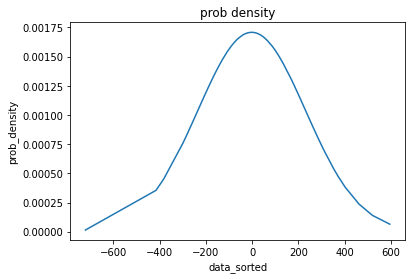

the action taked is: tf.Tensor([2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(387.19174, shape=(), dtype=float32)


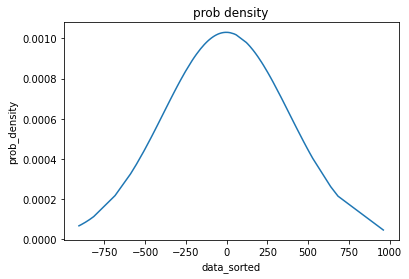

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-1.9889563, shape=(), dtype=float32)
sigma is  tf.Tensor(154.73024, shape=(), dtype=float32)


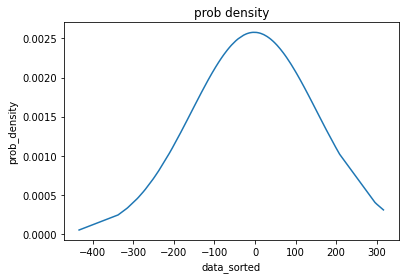

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(633.4248, shape=(), dtype=float32)


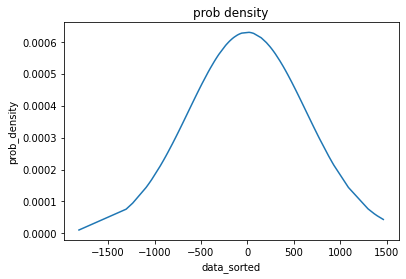

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(450.37433, shape=(), dtype=float32)


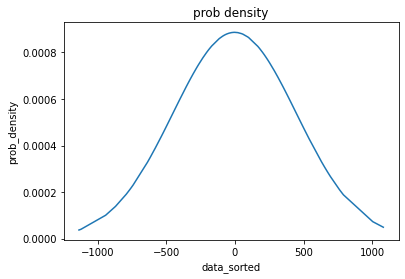

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(759.58185, shape=(), dtype=float32)


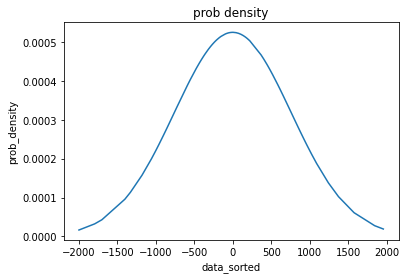

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(428.92245, shape=(), dtype=float32)


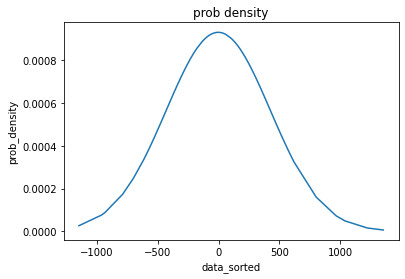

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(840.58777, shape=(), dtype=float32)


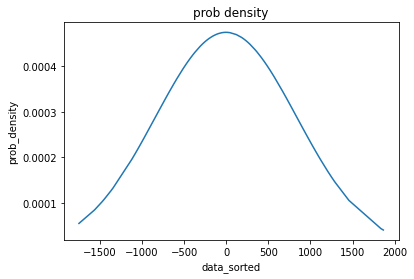

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(355.5587, shape=(), dtype=float32)


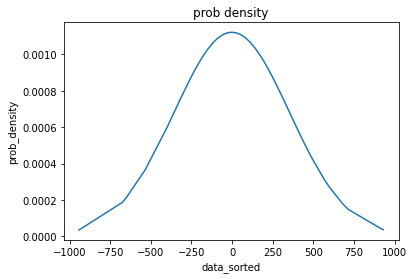

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-1.9999897, shape=(), dtype=float32)
sigma is  tf.Tensor(186.9867, shape=(), dtype=float32)


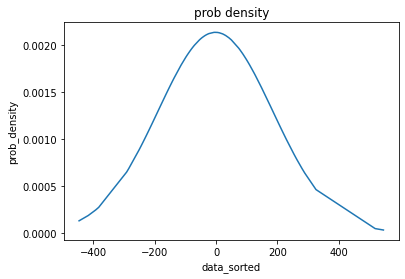

the action taked is: tf.Tensor([2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(563.006, shape=(), dtype=float32)


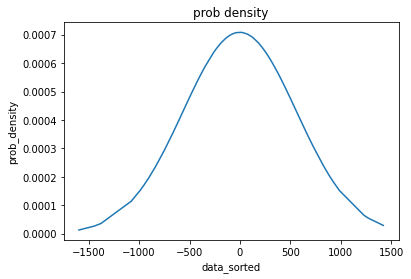

the action taked is: tf.Tensor([2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(372.3253, shape=(), dtype=float32)


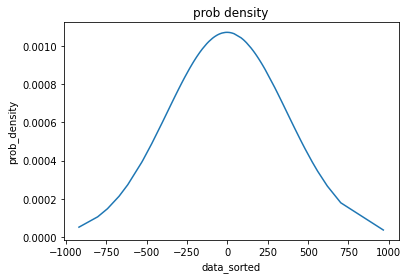

the action taked is: tf.Tensor([2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(743.7105, shape=(), dtype=float32)


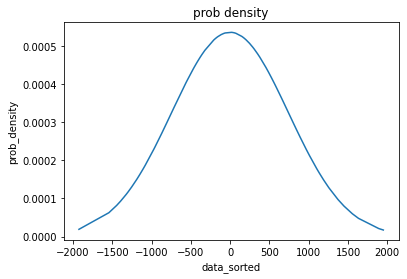

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(446.3101, shape=(), dtype=float32)


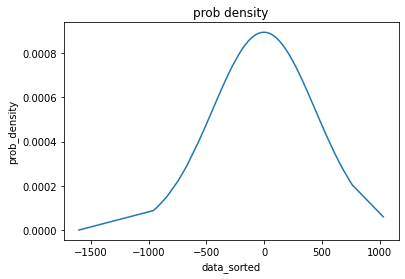

the action taked is: tf.Tensor([2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(460.63718, shape=(), dtype=float32)


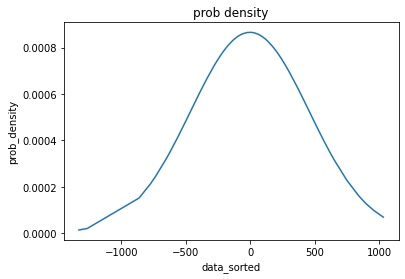

the action taked is: tf.Tensor([-2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-1.9998084, shape=(), dtype=float32)
sigma is  tf.Tensor(143.96872, shape=(), dtype=float32)


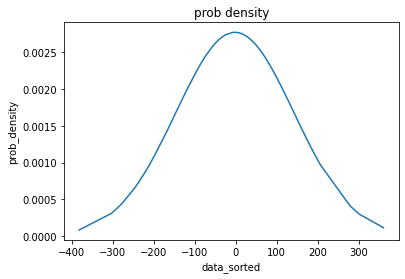

the action taked is: tf.Tensor([2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(154.2461, shape=(), dtype=float32)


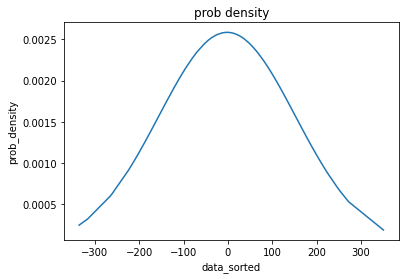

the action taked is: tf.Tensor([2.], shape=(1,), dtype=float32)
mu is  tf.Tensor(-2.0, shape=(), dtype=float32)
sigma is  tf.Tensor(389.7056, shape=(), dtype=float32)


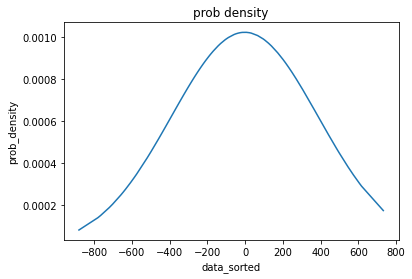

the action taked is: tf.Tensor([-0.6430521], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.489265, shape=(), dtype=float32)
sigma is  tf.Tensor(0.1000337, shape=(), dtype=float32)


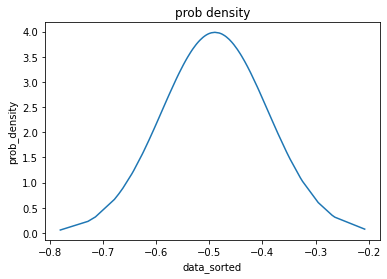

the action taked is: tf.Tensor([-0.67883825], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.63239694, shape=(), dtype=float32)
sigma is  tf.Tensor(0.100019544, shape=(), dtype=float32)


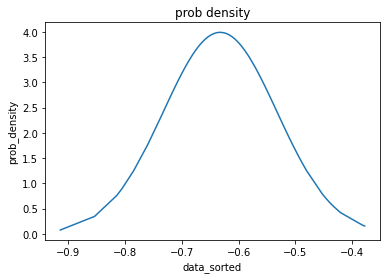

the action taked is: tf.Tensor([-0.6247055], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.4735209, shape=(), dtype=float32)
sigma is  tf.Tensor(0.1000154, shape=(), dtype=float32)


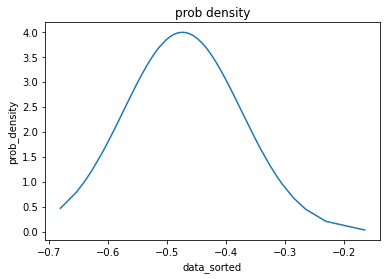

the action taked is: tf.Tensor([-0.52884364], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.56804025, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001643, shape=(), dtype=float32)


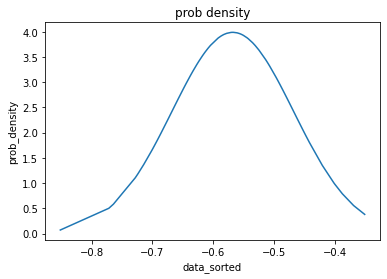

the action taked is: tf.Tensor([-0.42368835], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.45093343, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001528, shape=(), dtype=float32)


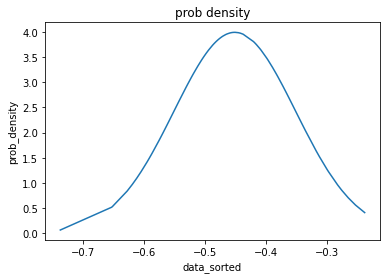

the action taked is: tf.Tensor([-0.48076692], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.45590904, shape=(), dtype=float32)
sigma is  tf.Tensor(0.1000149, shape=(), dtype=float32)


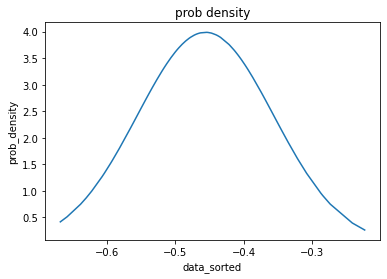

the action taked is: tf.Tensor([-0.37042022], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.5366423, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001581, shape=(), dtype=float32)


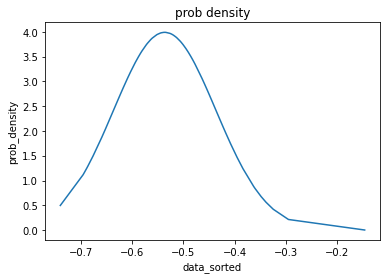

the action taked is: tf.Tensor([-0.5531098], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.71025777, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001853, shape=(), dtype=float32)


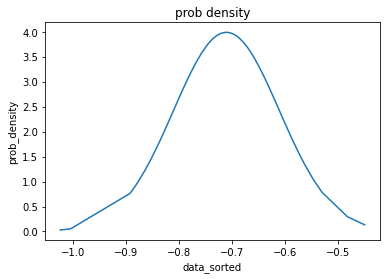

the action taked is: tf.Tensor([-0.61233866], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.54436284, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001593, shape=(), dtype=float32)


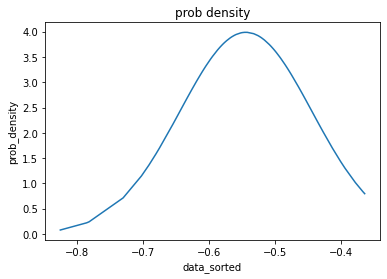

the action taked is: tf.Tensor([-0.58900535], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.5332483, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001631, shape=(), dtype=float32)


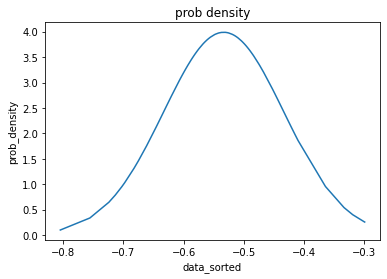

the action taked is: tf.Tensor([-0.8329976], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.55929923, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001637, shape=(), dtype=float32)


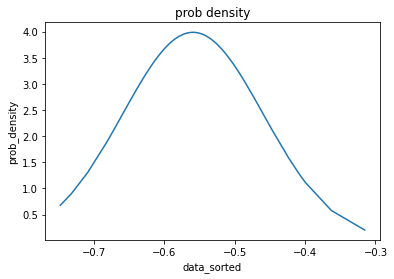

the action taked is: tf.Tensor([-0.6523564], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.56529856, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001613, shape=(), dtype=float32)


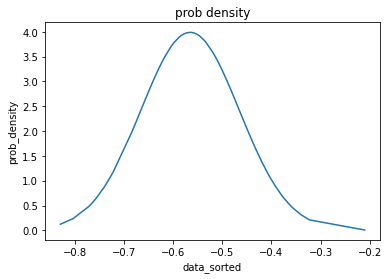

the action taked is: tf.Tensor([-0.49625582], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.5916673, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001696, shape=(), dtype=float32)


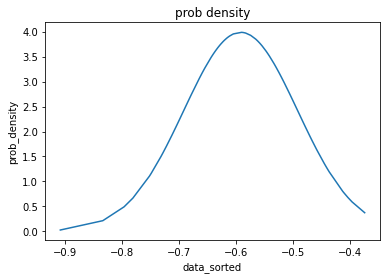

the action taked is: tf.Tensor([-0.5759792], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.5095518, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001619, shape=(), dtype=float32)


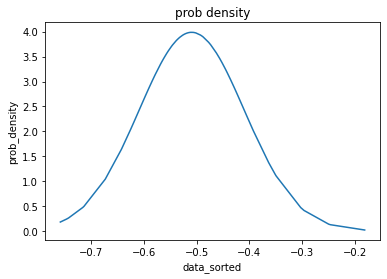

the action taked is: tf.Tensor([-0.4171802], shape=(1,), dtype=float32)
mu is  tf.Tensor(-0.3670747, shape=(), dtype=float32)
sigma is  tf.Tensor(0.10001395, shape=(), dtype=float32)


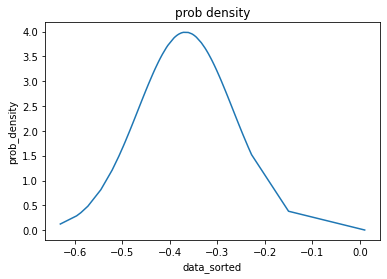

the action taked is: tf.Tensor([-0.56103283], shape=(1,), dtype=float32)


KeyboardInterrupt: 

In [9]:
for i_episode in range(MAX_EPISODE):
    s = env.reset()
    t = 0

    while True:
        env.render()
        a = actor_test.choose_action(s)
        
        if t%20 == 0:
            print('the action taked is:',a)
            actor_test.plot_gaosi(s)
            plt.show()
        

        s_, r, done, info = env.step(a)
        
        s = s_
        t += 1

     

# 观察输入输出


In [20]:
s = env.reset()
s

array([-0.35283079,  0.93568715,  0.02900014])

In [21]:
s = np.expand_dims(s, axis=0)  #给s加一个维度，以便于可以输入网络
[mu, sigma] = actor_test.Actor_net(s)  # mu,sigma是一个正态分布的两个参数mu，sigma
print('mu:', mu)
print('sigma:',sigma)

mu: tf.Tensor([[-1.]], shape=(1, 1), dtype=float32)
sigma: tf.Tensor([[334.39093]], shape=(1, 1), dtype=float32)


In [22]:
# 需要对这两个变量进行处理
mu = tf.squeeze(mu*2)
print('mu:', mu)
sigma = tf.squeeze(sigma + 0.1)
print('sigma:',sigma)

mu: tf.Tensor(-2.0, shape=(), dtype=float32)
sigma: tf.Tensor(334.49094, shape=(), dtype=float32)


In [23]:
#创建一个正态分布
normal_dist = tfp.distributions.Normal(mu, sigma)

In [24]:
act_choosed = tf.clip_by_value(normal_dist.sample(1), actor_test.action_bound[0], actor_test.action_bound[1])
print(act_choosed)

tf.Tensor([2.], shape=(1,), dtype=float32)


In [25]:
normal_dist.sample(1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([37.237488], dtype=float32)>

In [29]:
normal_dist.log_prob(-2)

<tf.Tensor: shape=(), dtype=float32, numpy=-6.7315483>